# Pontryagin Maximal Principle for real data

## Imports

In [14]:
import numpy as np
import scipy as sp
import pandas as pd
import math as math
import time
import matplotlib.pyplot as plt

from scipy.integrate import solve_ivp
from gekko import GEKKO
from tqdm import tqdm
from scipy.optimize import least_squares

import sys
import os
import numpy as np


## Next section

Propagating Uncertainty:  13%|█▎        | 66/501 [00:24<05:46,  1.25it/s]

❌ PMP failed: Shooting failed


Propagating Uncertainty:  14%|█▍        | 72/501 [00:30<07:29,  1.05s/it]

❌ PMP failed: Shooting failed


Propagating Uncertainty:  24%|██▍       | 121/501 [00:45<05:57,  1.06it/s]

❌ PMP failed: Shooting failed


Propagating Uncertainty:  27%|██▋       | 137/501 [00:52<05:48,  1.04it/s]

❌ PMP failed: Shooting failed


Propagating Uncertainty:  36%|███▌      | 179/501 [01:07<04:41,  1.14it/s]

❌ PMP failed: Shooting failed


Propagating Uncertainty:  38%|███▊      | 191/501 [01:12<04:31,  1.14it/s]

❌ PMP failed: Shooting failed


Propagating Uncertainty:  61%|██████    | 306/501 [01:57<03:09,  1.03it/s]

❌ PMP failed: Shooting failed


Propagating Uncertainty:  63%|██████▎   | 314/501 [02:01<02:53,  1.08it/s]

❌ PMP failed: Shooting failed


Propagating Uncertainty:  66%|██████▋   | 332/501 [02:08<01:40,  1.68it/s]

❌ PMP failed: Shooting failed


Propagating Uncertainty:  69%|██████▉   | 346/501 [02:16<02:26,  1.06it/s]

❌ PMP failed: Shooting failed


Propagating Uncertainty: 100%|██████████| 501/501 [03:01<00:00,  2.76it/s]


Estimated log-space noise std:
  Prey: 0.2186
  Predator: 0.2200


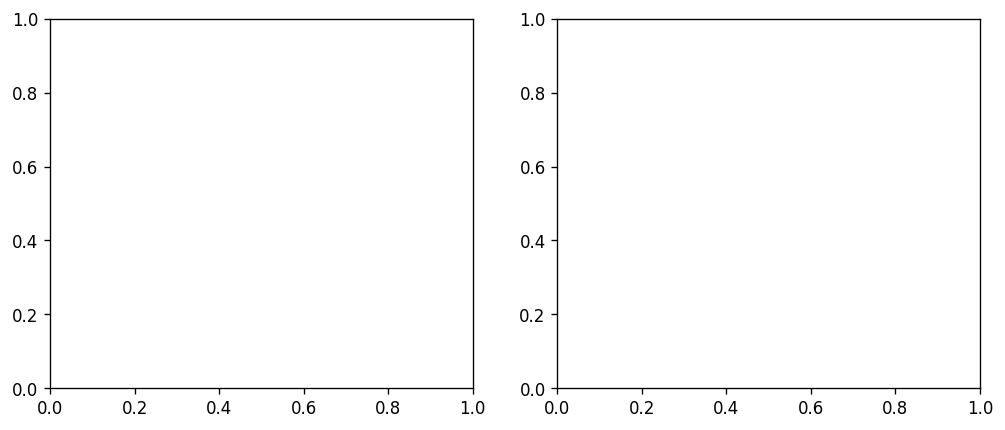

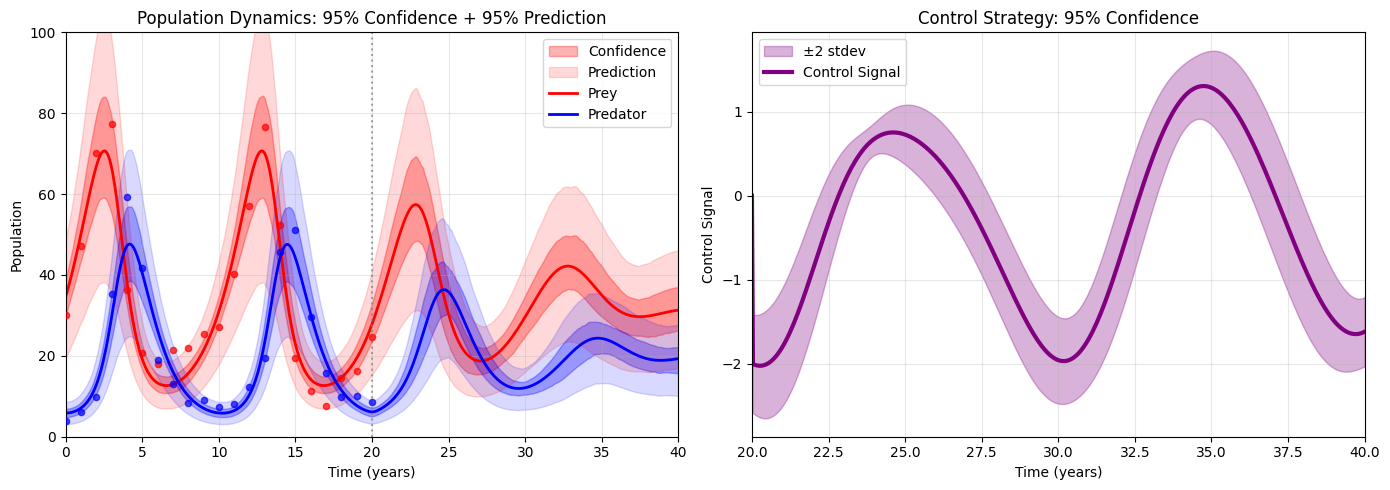

 Sample       Cost
      0  43.553521
      1  60.198122
      2  18.723590
      3  23.213564
      4  50.979930
      5  22.208665
      6  45.113618
      7  23.586281
      8  35.877832
      9  34.591683
     10  25.228114
     11  38.682869
     12  29.951732
     13  43.259970
     14  35.539913
     15  50.681220
     16  50.470421
     17  41.961958
     18  44.975320
     19  36.726764
     20  26.155073
     21  31.839765
     22  66.564718
     23  51.544473
     24  28.827933
     25  50.021091
     26  66.134168
     27  45.339829
     28  28.695174
     29  25.570274
     30  53.666917
     31  24.231893
     32  29.410474
     33  38.839278
     34  34.619602
     35  23.683416
     36  42.142975
     37  40.163057
     38  63.347124
     39  36.190419
     40  48.331259
     41  36.365396
     42  66.244524
     43  30.160171
     44  18.697948
     45  59.597454
     46  25.324513
     47  29.477741
     48  24.289345
     49  35.237102
     50  31.815437
     51  44.

C:\Users\lebda\AppData\Local\Temp\ipykernel_18592\3746855770.py:271: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  running = np.trapz(u_control**2, x=t_control)


In [ ]:

# ─── Load parameters and samples ───────────────────────────────────────────────────
param_path = r"C:\Users\lebda\source\repos\reu\final\real\parameter_estimation"
 
samples    = np.load(os.path.join(param_path, "real_samples.npy" )) # USE_THESE_PARAMETERS
parameters = np.mean(samples, axis=0)

# ─── Experimental data ────────────────────────────────────────────
prey_data = np.array([30.0, 47.2, 70.2, 77.4, 36.3, 20.6, 18.1, 21.4, 22.0, 25.4,
                      27.1, 40.3, 57.0, 76.6, 52.3, 19.5, 11.2, 7.6, 14.6, 16.2, 24.7])
predator_data = np.array([4.0, 6.1, 9.8, 35.2, 59.4, 41.7, 19.0, 13.0, 8.3, 9.1, 7.4,
                          8.0, 12.3, 19.5, 45.7, 51.1, 29.7, 15.8, 9.7, 10.1, 8.6])

# ─── Model definitions ────────────────────────────────────────────

def dynamics(t, x, u, p):
    prey, pred = x
    dprey = p['alpha'] * prey - p['beta'] * prey * pred
    dpred = -p['gamma'] * pred + p['delta'] * prey * pred - u
    return [dprey, dpred]

def costate(t, x, lam, u, p):
    prey, pred = x
    lam1, lam2 = lam
    dlam1 = - (lam1 * (p['alpha'] - p['beta'] * pred) + lam2 * (p['delta'] * pred))
    dlam2 = - (-lam1 * p['beta'] * prey + lam2 * (-p['gamma'] + p['delta'] * prey))
    return [dlam1, dlam2]

def optimal_control(t, x, lam, p):
    prey = x[0]
    lambda2 = lam[1]
    u_star = (lambda2) / 2
    return u_star if t >= 20 else 0.0

# Remaining content unchanged...

def full_system(t, y, dyn, cost, ctrl, p):
    n = len(y) // 2
    x = y[:n]
    lam = y[n:]
    u = ctrl(t, x, lam, p)
    dx = dyn(t, x, u, p)
    dl = cost(t, x, lam, u, p)
    return np.concatenate((dx, dl))

def shooting_function(lam0, x0, T, target, dyn, cost, ctrl, p):
    y0 = np.concatenate((x0, lam0))
    sol = solve_ivp(full_system, [0, T], y0, args=(dyn, cost, ctrl, p), dense_output=False)
    final = sol.y[:len(x0), -1]
    return final - target

def run_pmp(params, prey0, pred0, tf=40, t_eval=None):
    if t_eval is None:
        t_eval = np.linspace(0, tf, 600)

    α, β, γ, δ, _, _ = params[:6]
    p = {
        'alpha': α, 'beta': β, 'gamma': γ, 'delta': δ,
    }

    target = [γ / δ, α / β]
    x0 = [prey0, pred0]
    lam_init = [0.25, 0.25]

    try:
        soln = least_squares(shooting_function, lam_init,
                             args=(x0, tf, target, dynamics, costate, optimal_control, p),
                             xtol=1e-6, ftol=1e-6, gtol=1e-6)
        if not soln.success:
            raise RuntimeError("Shooting failed")

        lam0 = soln.x
        y0 = np.concatenate((x0, lam0))

        sol_c = solve_ivp(full_system, [0, tf], y0, t_eval=t_eval,
                          args=(dynamics, costate, optimal_control, p))
        N1, N2, L1, L2 = sol_c.y

        U = np.array([optimal_control(t, [n1, n2], [l1, l2], p)
                      for t, n1, n2, l1, l2 in zip(t_eval, N1, N2, L1, L2)])

        def zero_ctrl(t, x, lam, p): return 0.0
        sol_u = solve_ivp(full_system, [0, tf], y0, t_eval=t_eval,
                          args=(dynamics, costate, zero_ctrl, p))
        N1u, N2u = sol_u.y[:2]

        return {
            't': t_eval,
            'prey': N1,
            'predator': N2,
            'control': U,
            'prey_unc': N1u,
            'predator_unc': N2u
        }
    except Exception as e:
        print("❌ PMP failed:", e)
        return None

def propagate_uncertainty(samples, thinning=98):
    results = []
    thinned = samples[::thinning]
    for i, s in enumerate(tqdm(thinned, desc="Propagating Uncertainty")):
        out = run_pmp(s, s[4], s[5])
        if out is not None:
            results.append(out)
    return results

# Estimate measurement noise from residuals between model and data
t_data = np.arange(21)

# Run simulation
trajectories = propagate_uncertainty(samples, thinning=98)
if len(trajectories) == 0:
    sys.exit("No successful PMP trajectories.")

L = len(trajectories[1]['t'])
trajectories = [tr for tr in trajectories if all(len(tr[k]) == L for k in tr)]
time_grid = trajectories[0]['t']

all_prey = np.array([tr['prey'] for tr in trajectories])
all_predator = np.array([tr['predator'] for tr in trajectories])
all_control = np.array([tr['control'] for tr in trajectories])
all_prey_unc = np.array([tr['prey_unc'] for tr in trajectories])
all_pred_unc = np.array([tr['predator_unc'] for tr in trajectories])

prey_mean = np.mean(all_prey, axis=0)
prey_std = np.std(all_prey, axis=0)
pred_mean = np.mean(all_predator, axis=0)
pred_std = np.std(all_predator, axis=0)
ctrl_mean = np.mean(all_control, axis=0)
ctrl_std = np.std(all_control, axis=0)
prey_u_mean = np.mean(all_prey_unc, axis=0)
pred_u_mean = np.mean(all_pred_unc, axis=0)

# Interpolate model predictions at the times where data was measured
prey_model_at_data_times = np.interp(t_data, time_grid, prey_u_mean)
pred_model_at_data_times = np.interp(t_data, time_grid, pred_u_mean)

# Take logs before subtraction to match lognormal noise assumptions
log_prey_residuals = np.log(prey_data) - np.log(prey_model_at_data_times)
log_pred_residuals = np.log(predator_data) - np.log(pred_model_at_data_times)

# Estimate log-space noise std dev (i.e., the sigma parameter of the lognormal distribution)
prey_log_noise_std = np.std(log_prey_residuals)
pred_log_noise_std = np.std(log_pred_residuals)

# Optionally overwrite sigma or just report it
print(f"Estimated log-space noise std:\n  Prey: {prey_log_noise_std:.4f}\n  Predator: {pred_log_noise_std:.4f}")




# ─── Final Plot Block ─────────────────────────────────────────────────────
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=120)

# ─── Split time and state variables at t = 20 ──────────────────────────────
mask_pre = time_grid <= 20
mask_post = time_grid > 20
mask_ctrl = (time_grid >= 20) & (time_grid <= 40)

t_pre = time_grid[mask_pre]
t_post = time_grid[mask_post]
t_control = time_grid[mask_ctrl]

# Split state means and stds
prey_pre, prey_post = prey_mean[mask_pre], prey_mean[mask_post]
pred_pre, pred_post = pred_mean[mask_pre], pred_mean[mask_post]
prey_std_pre, prey_std_post = prey_std[mask_pre], prey_std[mask_post]
pred_std_pre, pred_std_post = pred_std[mask_pre], pred_std[mask_post]

ctrl_mean_control = ctrl_mean[mask_ctrl]
ctrl_std_control = ctrl_std[mask_ctrl]
# make sure control signal starts at 0
if t_control[0] > 20:
    t_control = np.insert(t_control, 0, 20)
    ctrl_mean_control = np.insert(ctrl_mean_control, 0, 0.0)
    ctrl_std_control = np.insert(ctrl_std_control, 0, 0.0)


import numpy as np
import matplotlib.pyplot as plt

# This version uses separate log-space sigmas for prey and predator in prediction intervals
# based on the log residuals between data and model predictions.

# This version uses separate log-space sigmas for prey and predator in prediction intervals
# based on the log residuals between data and model predictions.

# Replace this line:
sigma = 0.2218  # Lognormal noise std in log-space

# With these lines:
sigma_prey = prey_log_noise_std
sigma_pred = pred_log_noise_std

# Compute percentile-based confidence intervals
prey_traj_conf = np.percentile(all_prey, [2.5, 97.5], axis=0)
pred_traj_conf = np.percentile(all_predator, [2.5, 97.5], axis=0)
prey_traj_pred = prey_traj_conf * np.exp([-2 * sigma_prey, sigma_prey])[:, None]
pred_traj_pred = pred_traj_conf * np.exp([-2 * sigma_pred, sigma_pred])[:, None]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# PLOT 1: Population Dynamics – Confidence + Prediction
ax1.set_title("Population Dynamics: 95% Confidence + 95% Prediction")

# Confidence intervals
ax1.fill_between(time_grid, prey_traj_conf[0], prey_traj_conf[1], color='red', alpha=0.3, label='Confidence')
ax1.fill_between(time_grid, pred_traj_conf[0], pred_traj_conf[1], color='blue', alpha=0.3)

# Prediction intervals
ax1.fill_between(time_grid, prey_traj_pred[0], prey_traj_pred[1], color='red', alpha=0.15, label='Prediction')
ax1.fill_between(time_grid, pred_traj_pred[0], pred_traj_pred[1], color='blue', alpha=0.15)

# Mean trajectories
ax1.plot(time_grid, prey_mean, 'r-', lw=2, label='Prey')
ax1.plot(time_grid, pred_mean, 'b-', lw=2, label='Predator')

# Data points
ax1.scatter(t_data, prey_data, color='red', s=20, alpha=0.7, zorder=5)
ax1.scatter(t_data, predator_data, color='blue', s=20, alpha=0.7, zorder=5)
ax1.axvline(x=20, color='gray', linestyle=':', alpha=0.7)

ax1.set_xlabel('Time (years)')
ax1.set_ylabel('Population')
ax1.legend(loc='upper right')
ax1.grid(True, alpha=0.3)
ax1.set_xlim(0, 40)
ax1.set_ylim(0, 100)

# PLOT 2: Control Strategy – Confidence
ax2.set_title("Control Strategy: 95% Confidence")
ax2.fill_between(t_control,
                 ctrl_mean_control - 2*ctrl_std_control,
                 ctrl_mean_control + 2*ctrl_std_control,
                 color='purple', alpha=0.3, label='±2 stdev')
ax2.plot(t_control, ctrl_mean_control, 'purple', linewidth=3, label='Control Signal')
ax2.set_xlabel('Time (years)')
ax2.set_ylabel('Control Signal')
ax2.grid(True, alpha=0.3)
ax2.set_xlim(20, 40)
ax2.legend()

plt.tight_layout()
plt.show()

import pandas as pd
import numpy as np  # Needed for trapz

# ─── Cost Functional: terminal + running ────────────────────────────────
def compute_cost(traj, params):
    alpha, beta, gamma, delta = params[:4]

    # Target values from PMP setup
    target_pred = alpha / beta
    target_prey = gamma / delta

    # Extract trajectory values
    t = traj['t']
    prey = traj['prey']
    pred = traj['predator']
    control = traj['control']

    # Terminal cost (at final time)
    terminal = (prey[-1] - target_prey)**2 + (pred[-1] - target_pred)**2

    # Running cost (integral of control^2 from t = 20 onward)
    mask = t > 20
    t_control = t[mask]
    u_control = control[mask]
    running = np.trapz(u_control**2, x=t_control)

    return terminal + running

# ─── Loop over trajectories and compute cost ─────────────────────────────
costs = []
thinned_samples = samples[::98]

for i, (traj, param) in enumerate(zip(trajectories, thinned_samples)):
    cost = compute_cost(traj, param)
    costs.append({'Sample': i, 'Cost': cost})

# ─── Make a table with pandas and print ─────────────────────────────────
df = pd.DataFrame(costs)
print(df.to_string(index=False))
